In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
data_dir="E:\Work\Python\PythonTrainings\PythonMcKinsey\Data"
os.chdir(data_dir)

In [2]:
data=pd.read_csv("dm.csv",na_values=[""," ","NA","N/A"])

In [3]:
data.head()

,Age,Gender,OwnHome,Married,Location,Salary,Children,History,Catalogs,AmountSpent,Cust_Id
0,Old,Female,Own,Single,Far,47500,0,High,6,755,247
1,Middle,Male,Rent,Single,Close,63600,0,High,6,1318,127
2,Young,Female,Rent,Single,Close,13500,0,Low,18,296,479
3,Middle,Male,Own,Married,Close,85600,1,High,18,2436,475
4,Middle,Female,Own,Single,Close,68400,0,High,12,1304,151


In [4]:
## Assume people who spend more than the average are good customers
data['target']=data['AmountSpent'].map(lambda x: 1 if x>data['AmountSpent'].mean() else 0)

In [5]:
data['target'].describe().round(1)

count    1000.0
mean        0.4
std         0.5
min         0.0
25%         0.0
50%         0.0
75%         1.0
max         1.0
Name: target, dtype: float64

In [6]:
data=data.drop("AmountSpent",axis=1)

In [7]:
data.head()

,Age,Gender,OwnHome,Married,Location,Salary,Children,History,Catalogs,Cust_Id,target
0,Old,Female,Own,Single,Far,47500,0,High,6,247,0
1,Middle,Male,Rent,Single,Close,63600,0,High,6,127,1
2,Young,Female,Rent,Single,Close,13500,0,Low,18,479,0
3,Middle,Male,Own,Married,Close,85600,1,High,18,475,1
4,Middle,Female,Own,Single,Close,68400,0,High,12,151,1


In [8]:
## Minimal Data Prep
data['History']=data['History'].fillna("NewCust")

In [9]:
## Split the data into test and train
data_train=data.sample(frac=0.70,random_state=200)
data_test=data.drop(data_train.index)

In [10]:
## Build Model
import statsmodels.formula.api as smf
import statsmodels.api as sm

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [11]:
"+".join(data_train.drop(["target","Cust_Id"],axis=1).columns)

'Age+Gender+OwnHome+Married+Location+Salary+Children+History+Catalogs'

In [12]:
model1=smf.glm("target~C(Age)+C(Gender)+C(OwnHome)+C(Married)+C(Location)+Salary+Children+C(History)+Catalogs",data=data_train,
              family=sm.families.Binomial()).fit()

In [13]:
print(model1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 target   No. Observations:                  700
Model:                            GLM   Df Residuals:                      687
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -166.95
Date:                Tue, 28 Nov 2017   Deviance:                       333.91
Time:                        21:55:33   Pearson chi2:                     399.
No. Iterations:                    24                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -5.8262      1.187     -4.907      0.000      -8.153      -3.499
C(Age)[T.Old]      

In [14]:
## Variables to exclude
#Age
#Gender
#Ownhome
#Married
## Variables for dummy creation
#Hist_Low
#Hist_Medium

data_train['Hist_Low']=data_train['History'].map(lambda x: 1 if x=="Low" else 0)
data_test['Hist_Low']=data_test['History'].map(lambda x: 1 if x=="Low" else 0)
data_train['Hist_Med']=data_train['History'].map(lambda x: 1 if x=="Medium" else 0)
data_test['Hist_Med']=data_test['History'].map(lambda x: 1 if x=="Medium" else 0)

In [15]:
"+".join(data_train.drop(["target","Cust_Id"],axis=1).columns)

'Age+Gender+OwnHome+Married+Location+Salary+Children+History+Catalogs+Hist_Low+Hist_Med'

In [16]:
model2=smf.glm("target~Children+Catalogs+Salary+Hist_Low+Hist_Med",data=data_train,
              family=sm.families.Binomial()).fit()

In [17]:
print(model2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 target   No. Observations:                  700
Model:                            GLM   Df Residuals:                      694
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -178.58
Date:                Tue, 28 Nov 2017   Deviance:                       357.15
Time:                        21:55:39   Pearson chi2:                     413.
No. Iterations:                    24                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.0297      0.617     -9.773      0.000      -7.239      -4.820
Children      -0.4514      0.146     -3.098      0.0

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
features="Children+Catalogs+Salary+Hist_Low+Hist_Med"
y,X=dmatrices('target~'+features,data=data_train,return_type="dataframe")

In [19]:
vif=pd.DataFrame()
vif['VIF']=[variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['Features']=X.columns
vif.round(1)

,VIF,Features
0,13.3,Intercept
1,1.1,Children
2,1.1,Catalogs
3,1.3,Salary
4,1.6,Hist_Low
5,1.1,Hist_Med


In [20]:
## Let's check confusion matrix and AUC
import sklearn.metrics as metrics

In [21]:
y_true=data_test['target']
y_pred=model2.predict(data_test).map(lambda x:1 if x>0.5 else 0)
metrics.confusion_matrix(y_true,y_pred)

array([[160,  14],
       [ 18, 108]], dtype=int64)

In [22]:
## ROC curve
y_score=model2.predict(data_test)
fpr,tpr,thresholds=metrics.roc_curve(y_true,y_score)

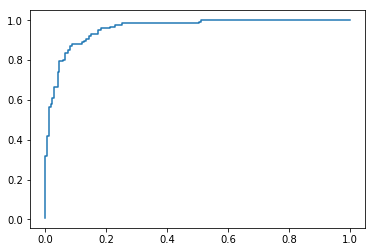

In [23]:
plt.plot(fpr,tpr,"-")

In [24]:
## AUC
metrics.roc_auc_score(y_true,y_score)

0.95785440613026818

In [25]:
## Gains
data_test['prob']=model2.predict(data_test)

In [27]:
data_test['prob_deciles']=pd.qcut(data_test['prob'],q=10)

In [28]:
data_test.head()

,Age,Gender,OwnHome,Married,Location,Salary,Children,History,Catalogs,Cust_Id,target,Hist_Low,Hist_Med,prob,prob_deciles
0,Old,Female,Own,Single,Far,47500,0,High,6,247,0,0,0,1.508562e-01,"(0.111, 0.292]"
2,Young,Female,Rent,Single,Close,13500,0,Low,18,479,0,1,0,1.540977e-12,"(3.73e-13, 8.09e-11]"
6,Middle,Female,Rent,Single,Close,48100,0,Medium,12,804,0,0,1,5.859476e-02,"(0.0414, 0.111]"
7,Middle,Male,Own,Single,Close,68400,0,High,18,790,0,0,0,8.929858e-01,"(0.806, 0.93]"
10,Young,Male,Rent,Married,Close,43700,1,NewCust,12,157,0,0,0,2.370725e-01,"(0.111, 0.292]"


In [29]:
data_test.sort_values('prob',ascending=False).head()

,Age,Gender,OwnHome,Married,Location,Salary,Children,History,Catalogs,Cust_Id,target,Hist_Low,Hist_Med,prob,prob_deciles
901,Old,Female,Own,Married,Far,128700,0,High,24,1164,1,0,0,0.999286,"(0.971, 0.999]"
386,Old,Male,Own,Married,Close,123000,0,High,24,584,1,0,0,0.998972,"(0.971, 0.999]"
216,Middle,Female,Rent,Married,Far,120800,1,High,24,1227,1,0,0,0.998142,"(0.971, 0.999]"
928,Old,Male,Own,Married,Close,168800,0,High,6,1286,1,0,0,0.997658,"(0.971, 0.999]"
263,Middle,Female,Rent,Married,Close,114100,1,NewCust,24,571,1,0,0,0.997147,"(0.971, 0.999]"


In [30]:
gains=data_test.groupby("prob_deciles",as_index=False)['target'].agg(['sum','count']).reset_index().sort_values("prob_deciles",
                 ascending=False)

In [31]:
gains.columns=["Deciles","TotalEvents","NumberObs"]

In [32]:
gains["PercEvents"]=gains['TotalEvents']/gains['TotalEvents'].sum()

In [33]:
gains["CumulativeEvents"]=gains.PercEvents.cumsum()

In [34]:
gains

,Deciles,TotalEvents,NumberObs,PercEvents,CumulativeEvents
9,"(0.971, 0.999]",30,30,0.238095,0.238095
8,"(0.93, 0.971]",28,30,0.222222,0.460317
7,"(0.806, 0.93]",26,30,0.206349,0.666667
6,"(0.524, 0.806]",23,30,0.182540,0.849206
5,"(0.292, 0.524]",13,30,0.103175,0.952381
4,"(0.111, 0.292]",4,30,0.031746,0.984127
3,"(0.0414, 0.111]",0,30,0.000000,0.984127
2,"(8.09e-11, 0.0414]",2,30,0.015873,1.000000
1,"(3.73e-13, 8.09e-11]",0,30,0.000000,1.000000
0,"(-0.000999999999973, 3.73e-13]",0,30,0.000000,1.000000


In [36]:
data_test.sort_values("prob",ascending=False)[['Cust_Id']].head(90)## These are the people to target

,Cust_Id
901,1164
386,584
216,1227
928,1286
263,571
887,789
625,1050
504,1276
52,230
351,1275
